# LDA with Mean-field VI

**Goal:** Translating the math in slide 25 of lecture 22 to an efficient piece of code.

**Dataset:** State of the Union---same as the previous exercise.

**Dependencies:**

1. `pip install tqdm, sklearn, scipy, numpy, spacy, matplotlib`
2. `python -m spacy download en_core_web_sm`
3. Unzip `Exercise_10_data.zip`, make sure you have the following directory structure: `./data/sotu/`

**Useful external references:**
1. https://arxiv.org/abs/1601.00670 (Also very useful for supplementing what you have seen in the lecture.)
2. http://times.cs.uiuc.edu/course/598f16/notes/lda-survey.pdf

We use the pre-processed texts from the previous exercise.

In [12]:
import numpy as np
import pickle
import tqdm
from scipy.special import digamma
from sklearn.feature_extraction.text import CountVectorizer


DATA_DIR = './data/'
SOTU_DIR = DATA_DIR + 'sotu/'

# Reduce these values to make things faster, e.g. for debugging
MAX_DOC_LEN = 1000
VOCAB_SIZE = 500


with open(DATA_DIR+'years.bin', 'rb') as f:
    years = pickle.load(f)

with open(DATA_DIR+'preprocessed.bin', 'rb') as f:
    preprocessed = pickle.load(f)

count_vect = CountVectorizer(max_features=VOCAB_SIZE, stop_words=['000'])
X = count_vect.fit_transform(preprocessed)

X = np.asarray(X.todense())

print(X.shape)


word2idx = count_vect.vocabulary_
idx2word = count_vect.get_feature_names()

(228, 500)


Create the features matrix that we are going to use during inference.

In [13]:
D = len(preprocessed)  # num of docs
V = count_vect.max_features  # vocabulary size

W = np.zeros([D, MAX_DOC_LEN, V], dtype='int8')  # Dataset

W_idx = []

for d, doc in enumerate(preprocessed):
    w = []
    
    for word in doc.split(' '):
        try:
            idx = word2idx[word]
            w.append(idx)
        except KeyError:
            pass
        
        if len(w) >= MAX_DOC_LEN:
            break
          
    W_idx.append(w)
        
    for i, w_ in enumerate(w):
        W[d, i, w_] = 1

## LDA inference with VI

Recall that in Gibbs sampling (previous exercise), we _sample_ latent variables from the LDA posterior (the LDA model conditioned to documents). In VI, we do a _full distribution approximation_ to the posterior instead. Specifically, we put a simplifying (mean-field) assumption on our model and optimize the reverse KL-divergence between the model and the true posterior.

VI can be seen as casting inference into optimization. While one can use any optimization algorithm to maximize the variational bound (ELBO), here we will implement the simplest algorithm for doing so. The algorithm is termed coordinate-ascent variational-inference (CAVI). It updates each variational distribution in turn using the full-conditional of the corresponding variable. The resulting algorithm is very similar to Gibbs sampling, but to emphasize it again: we do a _full distribution approximation_ to the posterior, and not _sampling_.

**Hint.** The pseudocode for the aforementioned algorithm is in slide 25 of lecture 22.

Let us start with some hyperparameters, similar to the previous exercise sheet.

In [14]:
K = 10  # num of topics

# Dirichlet priors
alpha = 1/K
beta = 1/K

**TASK 1.** Initialize the variational parameters of the three variational distributions:

* $\mathbf{\tilde{\alpha}}_d$, the variational parameter of $q(\mathbf{\pi}_d)$
* $\mathbf{\tilde{\beta}}_k$, the variational parameter of $q(\mathbf{\theta}_k)$
* $\mathbf{\tilde{\gamma}}_{di}$, the variational parameter of $q(\mathbf{c}_{di})$

Vectorize as much as you can---the data structure you choose affects the optimization runtime.

Note again: These variables are parameters to the variational distributions, not for holding samples like in Gibbs sampling.

In [15]:
def softmax(x):
    x -= np.max(x)
    x = np.exp(x)
    return x / x.sum()


In [16]:
def init_params():
    
    # Set random seed
    np.random.seed(0)
    
    # gamma_tilde := variational parameters of the distributions of the document-word topic assigments
    gamma_tilde = np.zeros((D, MAX_DOC_LEN, K))
    
    for d in range(len(W_idx)):
        w = W_idx[d]
        for i in range(len(w)):
            gamma_tilde[d, i, :] = np.random.dirichlet(np.ones(K) * alpha)
        
    # alpha_tilde := variational parameters of the document-topic distributions
    alpha_tilde = np.ones((D, K)) * alpha

    # beta_tilde := variational parameters of the topic-word distributions
    beta_tilde = np.ones((K, V)) * beta
    
    return alpha_tilde, beta_tilde, gamma_tilde

Now we will "translate" the pseudocode in the lecture slides into a real (efficient!) code. 

**TASK 2.** Inside the CAVI loop, update $(\mathbf{\tilde{\alpha}}_d), (\mathbf{\tilde{\beta}}_k), (\mathbf{\tilde{\gamma}}_{di})$ in turn. Vectorize the update as much as you can!

Note that, the computation of the ELBO is not necessary and you can skip this step. 

In [17]:
def run(N_ITER=20):
    
    alpha_tilde, beta_tilde, gamma_tilde = init_params()

    for it in tqdm.trange(N_ITER):

        # Update alpha_tilde
        # ------------------
        alpha_tilde = alpha + np.sum(gamma_tilde, axis=1)

        # Update beta_tilde
        # -----------------
        beta_tilde = beta + np.tensordot(gamma_tilde, W, axes=([0, 1], [0, 1]))

        # Update gamma_tilde
        # ------------------
        
        # Pre-compute digamma functions
        dg_alpha = digamma(alpha_tilde)
        dg_beta_1 = digamma(beta_tilde)
        dg_beta_2 = digamma(beta_tilde.sum(axis=1))
        
        for d in range(D):
            
            # Get list of word indices
            w = W_idx[d]

            for i in range(len(w)):
                
                # Get vocabulary word index
                v = w[i]

                for k in range(K):
                    
                    # Compute digamma sum
                    gamma_tilde[d, i, k] = dg_alpha[d, k] + dg_beta_1[k, v] - dg_beta_2[k]

                # Normalize
                gamma_tilde[d, i, :] = softmax(gamma_tilde[d, i, :])

    return alpha_tilde, beta_tilde, gamma_tilde

In [18]:
a, b, g = run(20)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:31<00:00,  4.57s/it]


## Testing

After we have successfully found all the variational parameters (and thus the variational distributions), we are ready to evaluate the inferred latent variables.

**TASK 3.** Print the _expected_ top-$n$ words for each topic, weigthed by its importance! To do this, recall, for each topic $k$, which variational distribution approximates the $k$-th topic-word distribution. See the previous exercise sheet (Sheet 10) for the explanation of "importance weigthing".

**Hint.** Expected result:

```
Topic-1
company dollar financial century income wage cost export

Topic-2
commissioner states vessel naval convention minister island treaty

Topic-3
china cent currency bond expenditure surplus bank gold

Topic-4
enemy fight war defense production military strength army

...
```

In [19]:
n = 8

def get_top_words(n_words, verbose=False):
    top_words = []

    for k in range(K):
        betas = b[k, :]
        word_idx = np.argsort(betas)[-n_words:]

        if verbose:
            print(f"===== Topic {k} =====")
        
        tw = []
        
        for idx in word_idx:
            w = idx2word[idx]
            tw.append(w)
            
            if verbose:
                print(w)
            
        top_words.append(tw)
        
        if verbose:
            print()
        
    return top_words

top_w = get_top_words(n, verbose=True)

===== Topic 0 =====
condition
interest
subject
present
power
country
public
law

===== Topic 1 =====
nation
people
duty
citizen
year
public
country
interest

===== Topic 2 =====
american
time
nation
man
year
great
war
people

===== Topic 3 =====
commerce
convention
duty
claim
citizen
country
subject
treaty

===== Topic 4 =====
time
increase
great
public
nation
interest
country
year

===== Topic 5 =====
year
time
public
power
act
nation
country
great

===== Topic 6 =====
peace
nation
great
force
law
power
country
war

===== Topic 7 =====
program
people
child
job
help
work
new
year

===== Topic 8 =====
peace
free
business
great
people
man
nation
world

===== Topic 9 =====
economic
national
people
price
need
world
increase
year



Finally, as before, let us visualize the change of topics over time.

**TASK 4.** Plot the _expected_ document-topic proportion sequentially, ordered by year. See Fig. 5 in https://arxiv.org/abs/1110.4713 for an example!

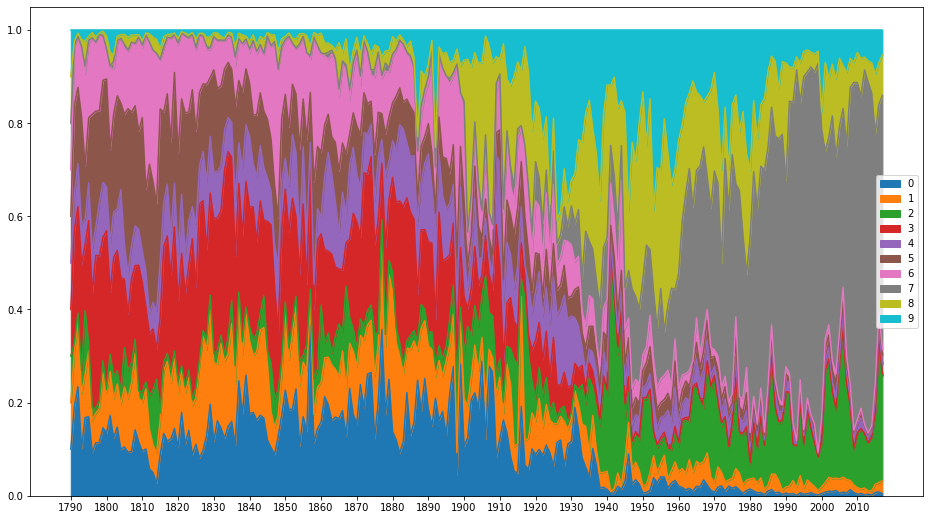

,0,1,2,3,4,5,6,7,8,9
0,condition,nation,american,commerce,time,year,peace,program,peace,economic
1,interest,people,time,convention,increase,time,nation,people,free,national
2,subject,duty,nation,duty,great,public,great,child,business,people
3,present,citizen,man,claim,public,power,force,job,great,price
4,power,year,year,citizen,nation,act,law,help,people,need
5,country,public,great,country,interest,nation,power,work,man,world
6,public,country,war,subject,country,country,country,new,nation,increase
7,law,interest,people,treaty,year,great,war,year,world,year


In [20]:
import matplotlib.pyplot as plt
import pandas as pd

order = np.array(years).argsort()
ordered_alphas = a[order, :]
ordered_alphas = ordered_alphas / ordered_alphas.sum(axis=1, keepdims=True)

tw = get_top_words(8)

plt.figure(figsize=(16, 9))
ax = plt.gca()
df = pd.DataFrame(ordered_alphas)
df.plot.area(ax=ax)
plt.xticks(np.arange(len(years), step=10), np.arange(min(years), max(years), 10))
plt.show()

pd.DataFrame(tw).T